# Sample code
This notebook contains some sample code to produce som of the results in the paper. Feel free to play around and see how it works. For full re-creation of the results in the paper, see the `README.md`.

### Imports

In [42]:
from typing import Generator, List, Optional

import numpy as np
import pandas as pd
from application.constants import DATA_DIR, RESULTS_DIR
from data_centric_synth.data_models.experiment3 import Experiment3Dataset
from data_centric_synth.datasets.openml.openml_loaders import (
    get_openml_benchmark_suite_task_ids,
    get_task_X_y,
)
import plotnine as pn
from plotnine.stats.stat_summary import mean_cl_boot
from wasabi import msg
from data_centric_synth.experiments.models import get_default_synthetic_model_suite
from data_centric_synth.experiments.run_experiments import run_main_experimental_loop
from data_centric_synth.utils import seed_everything
from sklearn.calibration import LabelEncoder
from IPython.display import Latex


from application.constants import DATA_DIR, RESULTS_DIR
from application.main_experiment.eval.summary_table import *
from application.main_experiment.eval.stat_fidelity import *
from application.main_experiment.eval.dataset_performance import *
from data_centric_synth.evaluation.extraction import get_experiment3_suite
from data_centric_synth.evaluation.postprocessing_real_data_only import (
    load_postprocessing_aggregated_statistical_fidelity,
)
from data_centric_synth.evaluation.summary_helpers import get_performance_dfs
from data_centric_synth.experiments.models import (
    IMPLEMENTED_DATA_CENTRIC_METHODS,
    get_default_synthetic_model_suite,
)


def load_main_experiment_datasets(n_datasets:int) -> Generator[Experiment3Dataset, None, None]:
    """Iterate over the datasets and yield X and y. Only yield if the dataset
    has less than 100_000 rows and less than 50 columns"""
    if n_datasets > 16:
        print("max number of datasets is 16, setting n_datasets to 16")
        n_datasets = 16
    for task_count, task in enumerate(get_openml_benchmark_suite_task_ids(suite_id=337)):
        if task_count >= n_datasets:
            break
        X, y = get_task_X_y(task_id=task)
        for col in X.columns:
            if X[col].dtype == "uint8":
                X[col] = X[col].astype(int)
        y = pd.Series(LabelEncoder().fit_transform(y))
        if X.shape[0] < 100_000 and X.shape[1] < 50:
            yield Experiment3Dataset(name=str(task), X=X, y=y.astype(int))

### Set constants including number of seeds and number of datasets

In [38]:
SAVE_DIR = DATA_DIR / "main_experiment" / "data"
SAVE_DIR.mkdir(exist_ok=True, parents=True)
N_SEEDS = 1
STARTING_SEED = 42
N_DATASETS = 1
seed_everything(seed=STARTING_SEED)

random_seeds = np.random.randint(0, 10000, size=N_SEEDS)

run_main_experimental_loop(
    datasets=load_main_experiment_datasets(N_DATASETS),
    save_dir=SAVE_DIR,
    random_seeds=random_seeds,
    synthetic_model_suite=get_default_synthetic_model_suite(),
)


2023-11-21 12:50:00	ℹ Running experiments for dataset 361055
2023-11-21 12:50:00	ℹ Saving to
/home/rob/Documents/projects/code_reviews/neurips_2023/data-centric-synthetic-data/data/main_experiment/data/361055
2023-11-21 12:50:00	ℹ Running experiment for seed 7270
2023-11-21 12:50:00	ℹ Skipping synthetic model tvae as it already exists in
/home/rob/Documents/projects/code_reviews/neurips_2023/data-centric-synthetic-data/data/main_experiment/data/361055/seed_7270/tvae.pkl
2023-11-21 12:50:00	ℹ Skipping synthetic model ctgan as it already exists in
/home/rob/Documents/projects/code_reviews/neurips_2023/data-centric-synthetic-data/data/main_experiment/data/361055/seed_7270/ctgan.pkl
2023-11-21 12:50:00	ℹ Skipping synthetic model bayesian_network as it already exists in
/home/rob/Documents/projects/code_reviews/neurips_2023/data-centric-synthetic-data/data/main_experiment/data/361055/seed_7270/bayesian_network.pkl
2023-11-21 12:50:00	ℹ Skipping synthetic model nflow as it already exists in


### Summary Table
Produce the latex required to produce the summary tables.

In [39]:
data_centric_methods: List[IMPLEMENTED_DATA_CENTRIC_METHODS] = [
    "cleanlab",
    "dataiq",
    "datamaps",
]
synthetic_models = [*get_default_synthetic_model_suite(), "None"]

dataset_dirs = DATA_DIR / "main_experiment" / "data"
plot_save_dir = RESULTS_DIR / "main_experiment" / "plots" / "summary"
plot_save_dir.mkdir(parents=True, exist_ok=True)

experiment_suite = get_experiment3_suite(dataset_dirs)

performance_dfs = get_performance_dfs(
    data_centric_methods, synthetic_models, experiment_suite
)
performances_dfs = rename_easy_ambi_to_no_hard(performance_dfs)
performance_dfs = rename_easy_ambiguous_hard_to_easy_ambi_hard(performance_dfs)

latex_tables = []

for data_centric_method in data_centric_methods:
    msg.divider(f"Data Centric Method: {data_centric_method}")
    ## Table 1: Performance across all datasets for baseline condition

    combined_unnormalized = aggregate_performance_across_tasks(
        classification_performance_df=performance_dfs.classification.query(
            "data_centric_method == @data_centric_method & classification_model_type == 'XGBClassifier' & metric == 'roc_auc'"
        ),
        model_selection_df=performance_dfs.model_selection.query(
            "data_centric_method == @data_centric_method"
        ),
        feature_selection_df=performance_dfs.feature_selection.query(
            "data_centric_method == @data_centric_method"
        ),
        by_cols=[
            "synthetic_model_type",
            "preprocessing_strategy",
            "postprocessing_strategy",
        ],
        normalize=False,
        normalize_index_col="",
    )
    # subset to only the baseline and org_data conditions
    combined_unnormalized = (
        combined_unnormalized.reset_index()
        .query(
            "(postprocessing_strategy == 'baseline' & preprocessing_strategy == 'baseline') | (preprocessing_strategy == 'org_data')"
        )
        .drop(columns=["postprocessing_strategy", "preprocessing_strategy"])
    )
    combined_unnormalized = combined_unnormalized.rename(
        {"synthetic_model_type": "Generative Model"}, axis=1
    ).reset_index(drop=True)

    if data_centric_method == "cleanlab":
        stat_fid = pd.read_csv(
            RESULTS_DIR / "main_experiment" / "tmp" / "aggregated_stat_fid.csv"
        ).rename({"mean (lower, upper)": "Statistical fidelity"}, axis=1)
        postprocessing_stat_fid_df = (
            load_postprocessing_aggregated_statistical_fidelity(
                metric="inv_kl_divergence"
            )
        )

        combined_unnormalized = combined_unnormalized.merge(
            stat_fid, how="left", on="Generative Model"
        )
    msg.info("Unnormalized performance -- baseline and org_data conditions")
    latex_tables.append(combined_unnormalized.to_latex(index=False))


    ## Table 2: Normalized performance across conditions
    combined_normalized = aggregate_performance_across_tasks(
        classification_performance_df=performance_dfs.classification.query(
            "data_centric_method == @data_centric_method & classification_model_type == 'XGBClassifier' & metric == 'roc_auc'"
        ),
        model_selection_df=performance_dfs.model_selection.query(
            "data_centric_method == @data_centric_method"
        ),
        feature_selection_df=performance_dfs.feature_selection.query(
            "data_centric_method == @data_centric_method"
        ),
        by_cols=[
            "synthetic_model_type",
            "preprocessing_strategy",
            "postprocessing_strategy",
        ],
        normalize=True,
        normalize_index_col="synthetic_model_type",
        digits=2,
    )
    # subset to not include the baseline and org_data conditions
    combined_normalized = (
        combined_normalized.reset_index()
        .query(
            "(postprocessing_strategy != 'baseline' | preprocessing_strategy != 'baseline') & preprocessing_strategy != 'org_data'"
        )
        .set_index(
            [
                "synthetic_model_type",
                "preprocessing_strategy",
                "postprocessing_strategy",
            ]
        )
    )
    combined_normalized.index = combined_normalized.index.rename(
        {
            "synthetic_model_type": "Generative Model",
            "preprocessing_strategy": "Preprocessing Strategy",
            "postprocessing_strategy": "Postprocessing Strategy",
        }
    )
    if data_centric_method == "cleanlab":
        stat_fid = (
            pd.read_csv(
                RESULTS_DIR / "main_experiment" / "tmp" / "normalized_stat_fid.csv"
            )
            .rename({"mean (lower, upper)": "Statistical fidelity"}, axis=1)
            .set_index(
                [
                    "Generative Model",
                    "Preprocessing Strategy",
                    "Postprocessing Strategy",
                ]
            )
        )
        combined_normalized = combined_normalized.join(stat_fid)
    msg.info("Normalized performance -- all conditions")
    aggregated_table_to_latex(combined_normalized)

    # Figure 3
    ## Figure X: performance by pre/post processing strategy for each model averaged over datasets
    perf = aggregate_performance_across_tasks_no_merging(
        classification_performance_df=performance_dfs.classification.query(
            "data_centric_method == @data_centric_method & classification_model_type == 'XGBClassifier' & metric == 'roc_auc' & synthetic_model_type != 'None'"
        ),
        model_selection_df=performance_dfs.model_selection.query(
            "data_centric_method == @data_centric_method & synthetic_model_type != 'None'"
        ),
        feature_selection_df=performance_dfs.feature_selection.query(
            "data_centric_method == @data_centric_method & synthetic_model_type != 'None'"
        ),
        by_cols=[
            "synthetic_model_type",
            "preprocessing_strategy",
            "postprocessing_strategy",
        ],
    )
    perf.index = perf.index.rename(
        {
            "synthetic_model_type": "Generative Model",
            "preprocessing_strategy": "Preprocessing Strategy",
            "postprocessing_strategy": "Postprocessing Strategy",
        }
    )
    perf = perf.reset_index()
    perf["processing"] = (
        perf["Preprocessing Strategy"] + "-" + perf["Postprocessing Strategy"]
    )

    # make tasks categorical with order Classification, Model Selection, Feature Selection
    perf["tasks"] = pd.Categorical(perf["tasks"], categories=perf["tasks"].unique())

    (
        pn.ggplot(
            perf,
            pn.aes(
                x="processing",
                y="mean",
                color="Generative Model",
                group="Generative Model",
            ),
        )
        + pn.geom_line()
        + pn.geom_point(size=3)
        + pn.facet_wrap("~tasks", scales="free_y")
        + pn.scale_x_discrete(expand=(0.05, 0.05))
        + pn.theme_minimal()
        + pn.theme(
            legend_position="bottom",
            legend_title=pn.element_blank(),
            # axis_title_x=pn.element_blank(),
            legend_box_margin=120,
            figure_size=(10, 3),
            axis_text_x=pn.element_text(angle=45),
            panel_spacing=0.5,
        )
        + pn.scale_color_brewer(type="qual", palette="Set2")  # type: ignore
        + pn.labs(y="Performance", x="Preprocessing-Postprocessing")
    ).save(
        plot_save_dir
        / f"{data_centric_method}_pre_post_processing_performance.png",
        dpi=300,
    )


======================= Data Centric Method: cleanlab =======================
ℹ Unnormalized performance -- baseline and org_data conditions
ℹ Normalized performance -- all conditions
\begin{tabular}{lllllll}
\toprule
     &           &         &       Classification &         Model Selection &        Feature Selection &      Statistical fidelity \\
Generative Model & Preprocessing Strategy & Postprocessing Strategy &                      &                         &                          &                           \\
\midrule
bayesian\_network & baseline & no\_hard &   0.31 (-4.59, 5.98) &  -27.73 (-88.39, 34.12) &   -52.26 (-158.77, 58.2) &    -0.007 (-0.055, 0.041) \\
     & easy\_hard & baseline &   0.35 (-4.98, 6.08) &   92.18 (25.83, 154.98) &    9.79 (-111.2, 135.83) &    -0.013 (-0.056, 0.026) \\
     &           & no\_hard &    0.8 (-4.65, 6.43) &    27.25 (-33.65, 87.2) &  -9.39 (-128.25, 112.15) &    -0.023 (-0.068, 0.021) \\
\midrule
 ctgan & baseline & no\_hard &   1.2

### Evaluate the fidelity

In [41]:
data_centric_methods: List[IMPLEMENTED_DATA_CENTRIC_METHODS] = [
    "cleanlab",
]
synthetic_models = [*get_default_synthetic_model_suite(), "None"]

# dataset_dirs = RESULTS_DIR / "experiment3" / "statistical_fidelity"
dataset_dirs = DATA_DIR / "main_experiment" / "statistical_fidelity"
plot_save_dir = RESULTS_DIR / "main_experiment" / "plots" / "summary"
plot_save_dir.mkdir(parents=True, exist_ok=True)

experiment_suite = get_statistical_fidelity_suite(dataset_dirs)
# save_to_pickle(experiment_suite, RESULTS_DIR / "experiment3" / "experiment_suite.pkl")

### BASELINE CONDITION
## Get statistical fidelity results, aggregate and save to csv for combination with other results

statistical_fidelity_df = get_statistical_fidelity_experiment_performance_df(
    experiment_suite=experiment_suite,
    synthetic_models=synthetic_models,
    data_centric_methods=data_centric_methods,
)
statistical_fidelity_df["postprocessing_strategy"] = statistical_fidelity_df[
    "postprocessing_strategy"
].replace({"easy_ambi": "no_hard"})

aggregated_stat_fid_df = aggregate_and_make_pretty(
    performance_df=statistical_fidelity_df.query(
        "data_centric_method == 'cleanlab'"
    ),
    by_cols=[
        "synthetic_model_type",
        "preprocessing_strategy",
        "postprocessing_strategy",
    ],
    value_col="inv_kl_divergence",
    normalize=False,
    normalize_index_col="",
    digits=3,
)
aggregated_stat_fid_df = (
    aggregated_stat_fid_df.reset_index()
    .query(
        "(postprocessing_strategy == 'baseline' & preprocessing_strategy == 'baseline') | (preprocessing_strategy == 'org_data')"
    )
    .drop(columns=["postprocessing_strategy", "preprocessing_strategy"])
)
aggregated_stat_fid_df = aggregated_stat_fid_df.rename(
    {"synthetic_model_type": "Generative Model"}, axis=1
)
save_path = RESULTS_DIR / "main_experiment" / "tmp" / "aggregated_stat_fid.csv"
# mkdir if not exists
save_path.parent.mkdir(parents=True, exist_ok=True)

aggregated_stat_fid_df.to_csv(
    save_path,
    index=False,
)

### NORMALIZED PERFORMANCE
normalized_stat_fid_df = aggregate_and_make_pretty(
    performance_df=statistical_fidelity_df.query(
        "data_centric_method == 'cleanlab'"
    ),
    by_cols=[
        "synthetic_model_type",
        "preprocessing_strategy",
        "postprocessing_strategy",
    ],
    value_col="inv_kl_divergence",
    normalize=True,
    normalize_index_col="synthetic_model_type",
    digits=3,
)
normalized_stat_fid_df = (
    normalized_stat_fid_df.reset_index()
    .query(
        "(postprocessing_strategy != 'baseline' | preprocessing_strategy != 'baseline') & preprocessing_strategy != 'org_data'"
    )
    .set_index(
        [
            "synthetic_model_type",
            "preprocessing_strategy",
            "postprocessing_strategy",
        ]
    )
)
normalized_stat_fid_df.index = normalized_stat_fid_df.index.rename(
    {
        "synthetic_model_type": "Generative Model",
        "preprocessing_strategy": "Preprocessing Strategy",
        "postprocessing_strategy": "Postprocessing Strategy",
    }
)
display(normalized_stat_fid_df)


mean (lower, upper)
Generative Model Preprocessing Strategy Postprocessing Strategy                          
bayesian_network baseline               no_hard                    -0.007 (-0.057, 0.044)
                 easy_hard              baseline                   -0.013 (-0.056, 0.027)
                                        no_hard                    -0.023 (-0.066, 0.021)
ctgan            baseline               no_hard                    -0.054 (-1.261, 0.796)
                 easy_hard              baseline                   -0.006 (-1.198, 0.792)
                                        no_hard                    -0.119 (-1.269, 0.714)
ddpm             baseline               no_hard                  -0.166 (-18.652, 15.935)
                 easy_hard              baseline                  0.356 (-16.504, 14.007)
                                        no_hard                   0.284 (-16.987, 14.709)
nflow            baseline               no_hard                       0.035 (-0.76, 0.69)
                 easy_hard              baseline                    0.022 (-0.818, 0.627)
                                        no_hard                     0.052 (-0.699, 0.696)
tvae             baseline               no_hard                    -0.053 (-1.378, 1.258)
                 easy_hard              baseline                     0.24 (-0.953, 1.286)
                                        no_hard                      0.199 (-0.917, 1.21)

## Produce dataset performance plots

In [45]:
data_centric_methods: List[IMPLEMENTED_DATA_CENTRIC_METHODS] = [
    "cleanlab",
    "dataiq",
    "datamaps",
]
synthetic_models = [*get_default_synthetic_model_suite(), "None"]

#dataset_dirs = RESULTS_DIR / "experiment3" / "data"
dataset_dirs = DATA_DIR / "main_experiment" / "data"
plot_save_dir = RESULTS_DIR / "main_experiment" / "plots" / "appendix"
plot_save_dir.mkdir(parents=True, exist_ok=True)

experiment_suite = get_experiment3_suite(dataset_dirs)

performance_dfs = get_performance_dfs(
    data_centric_methods, synthetic_models, experiment_suite
)
performances_dfs = rename_easy_ambi_to_no_hard(performance_dfs)
performance_dfs = rename_easy_ambiguous_hard_to_easy_ambi_hard(performance_dfs)

combined = aggregate_performance_across_tasks_no_merging(
    classification_performance_df=performance_dfs.classification.query(
        "data_centric_method == 'cleanlab' & metric == 'roc_auc' & classification_model_type == 'XGBClassifier'"
    ),
    model_selection_df=performance_dfs.model_selection.query(
        "data_centric_method == 'cleanlab'"
    ),
    feature_selection_df=performance_dfs.feature_selection.query(
        "data_centric_method == 'cleanlab'"
    ),
    by_cols=[
        "dataset_id",
        "synthetic_model_type",
        "preprocessing_strategy",
        "postprocessing_strategy",
    ],
).reset_index()
combined["processing"] = (
    combined["preprocessing_strategy"] + "-" + combined["postprocessing_strategy"]
)


#### Classification

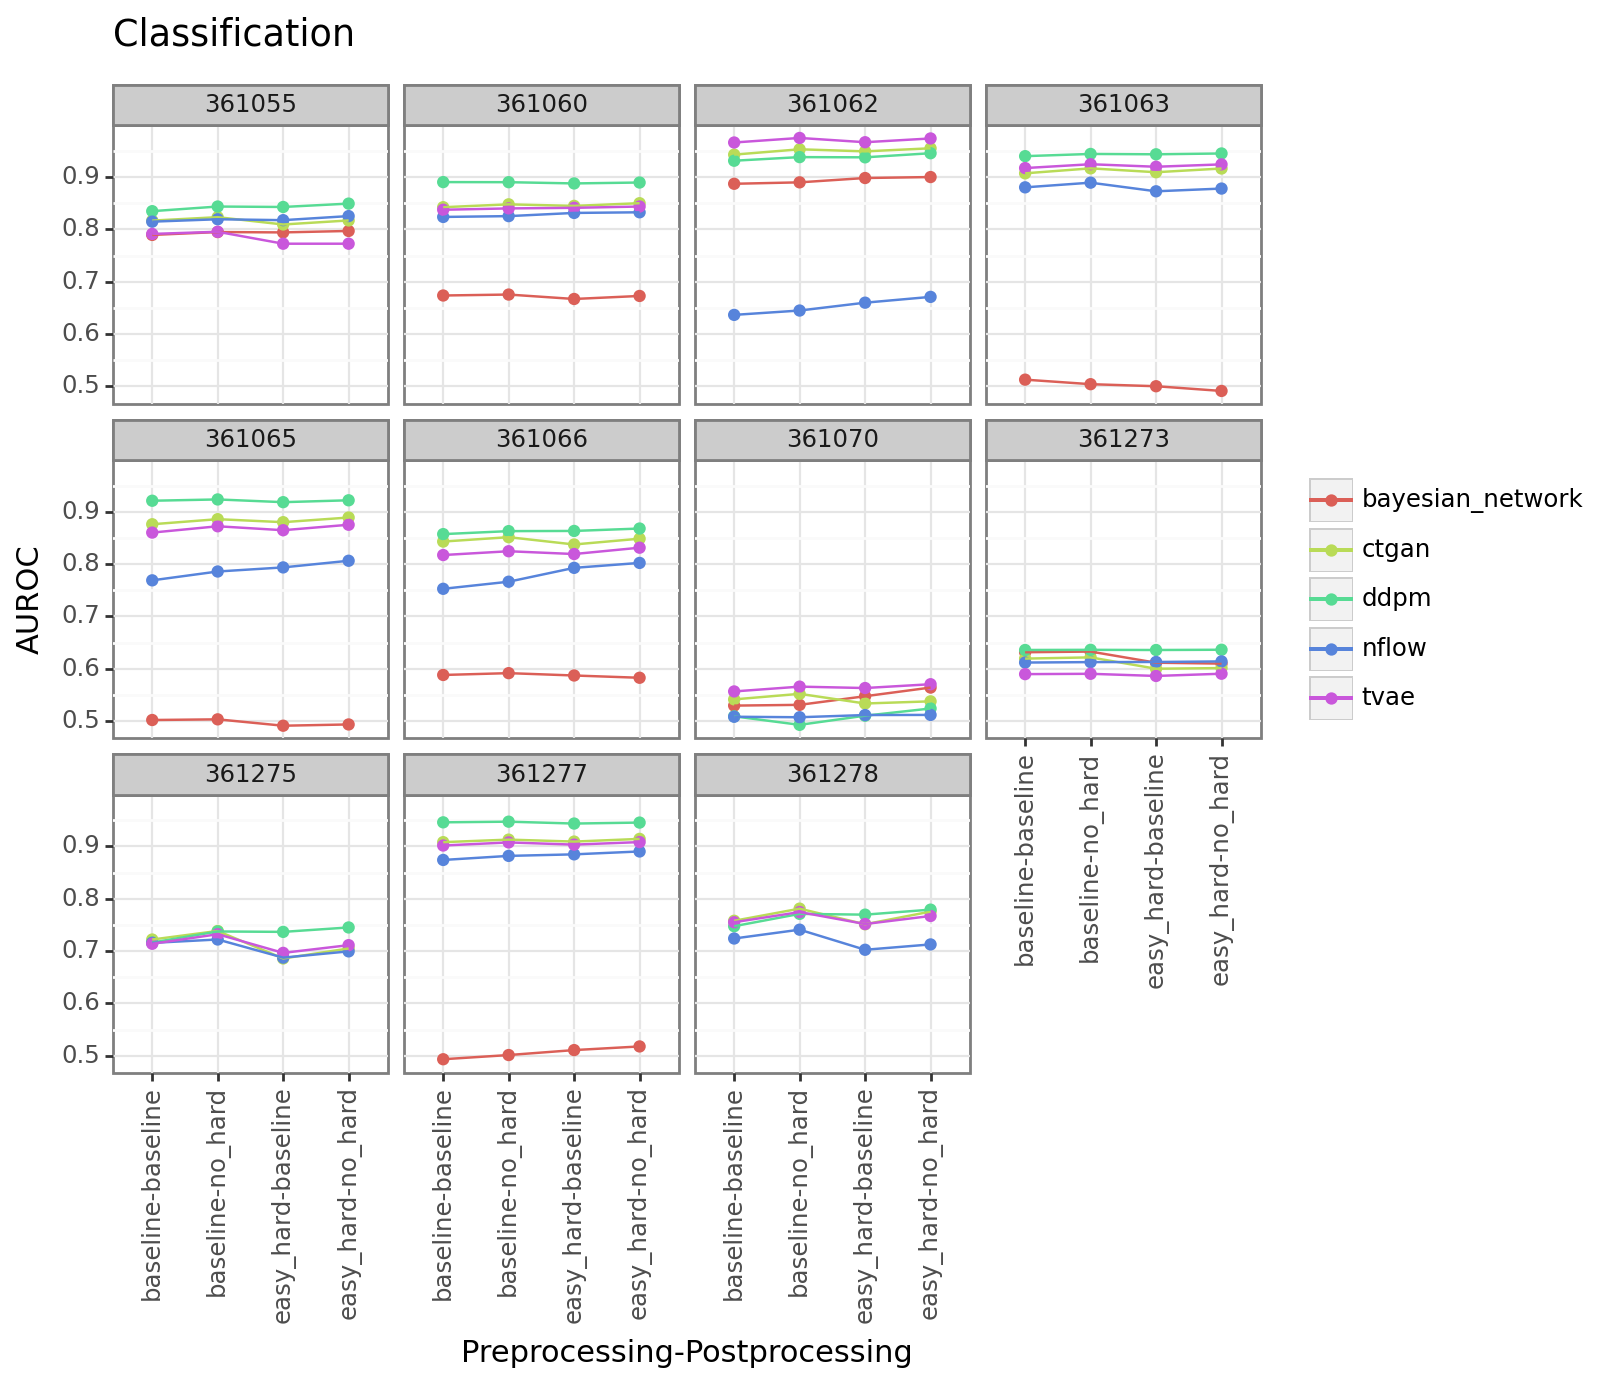

<Figure Size: (800 x 700)>

In [46]:

(
    plot_line_facet(
        combined.query("tasks == 'Classification' & synthetic_model_type != 'None'")
    )
    + pn.labs(x="Preprocessing-Postprocessing", y="AUROC", title="Classification")
    + pn.theme(
        figure_size=(8, 7),
        axis_text_x=pn.element_text(rotation=90),
        legend_title=pn.element_blank(),
    )
)


#### Model Selection

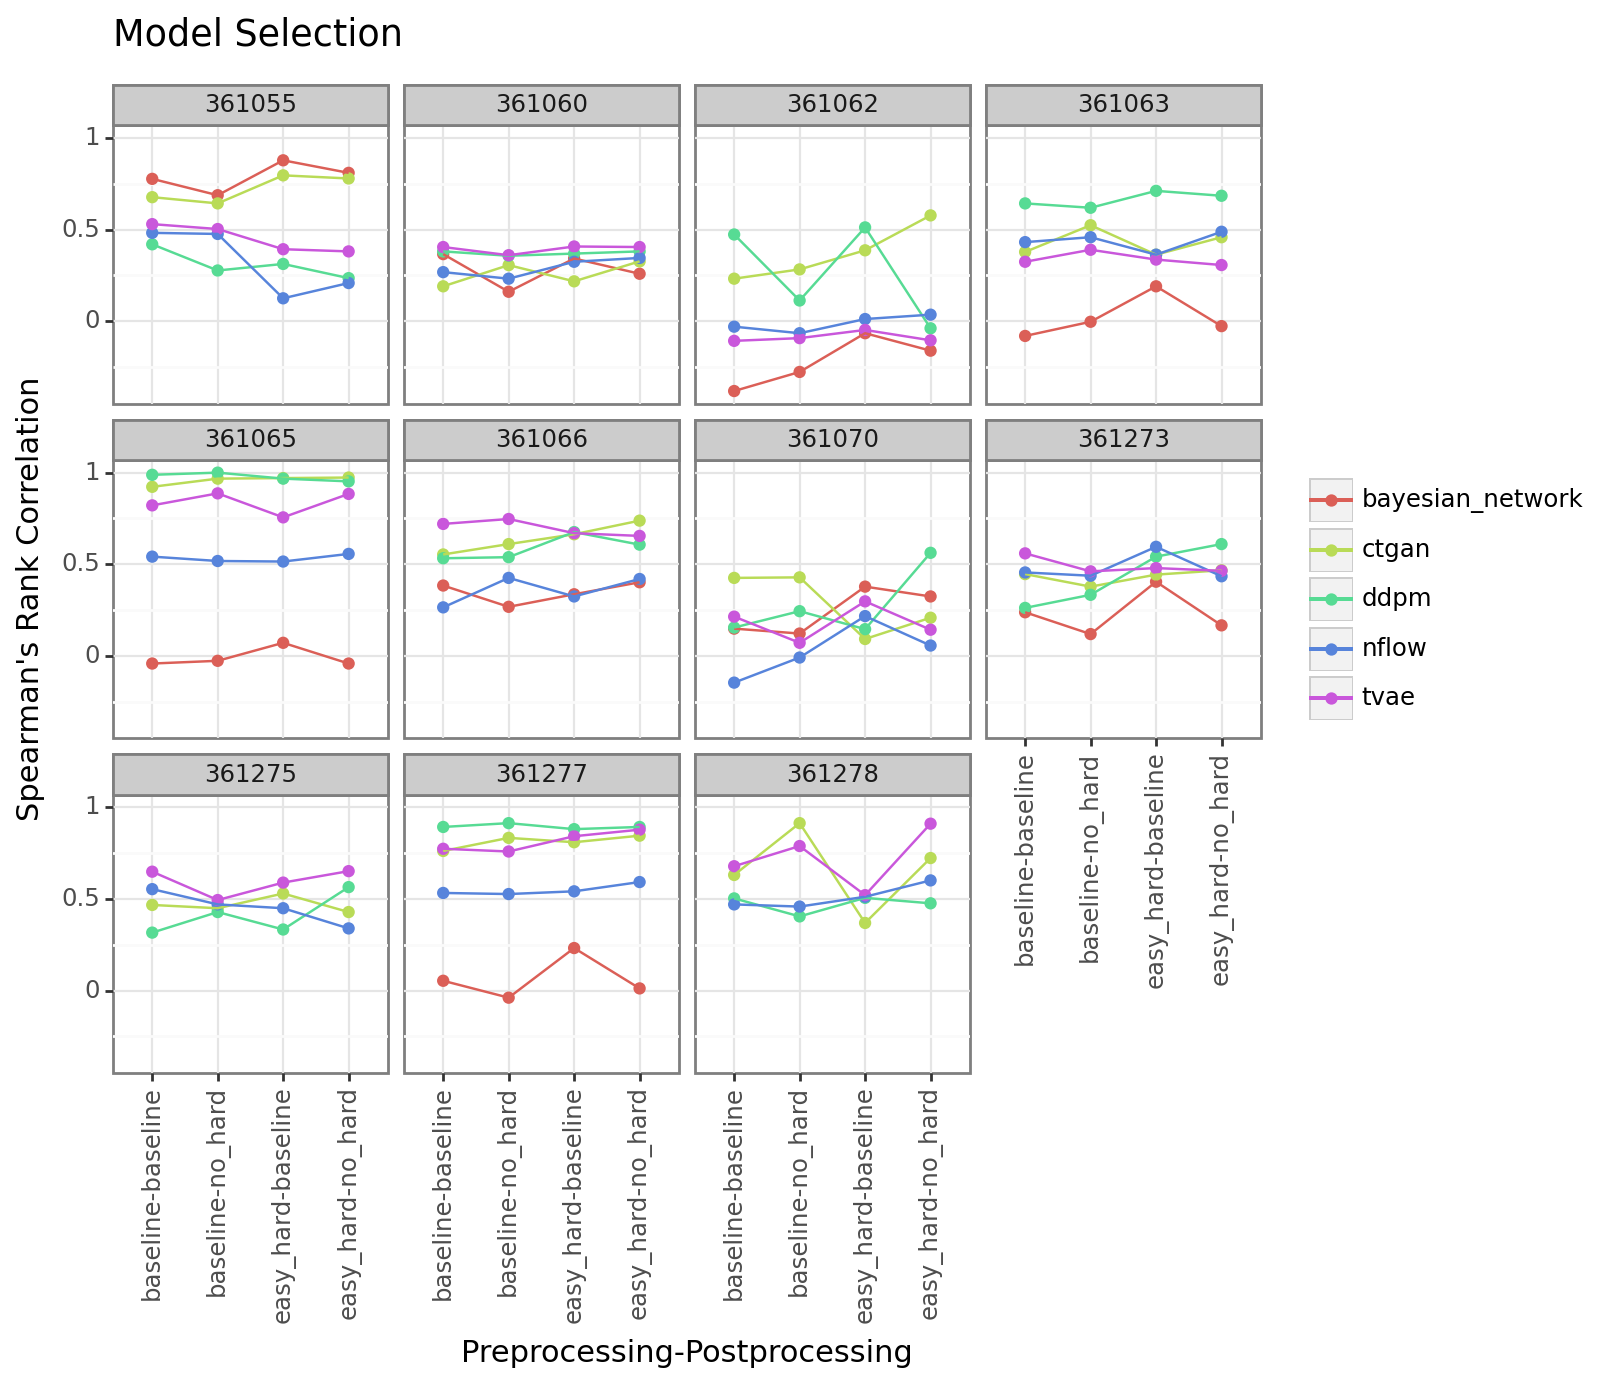

<Figure Size: (800 x 700)>

In [47]:

(
    plot_line_facet(combined.query("tasks == 'Model Selection'"))
    + pn.labs(
        x="Preprocessing-Postprocessing",
        y="Spearman's Rank Correlation",
        title="Model Selection",
    )
    + pn.theme(
        figure_size=(8, 7),
        axis_text_x=pn.element_text(rotation=90),
        legend_title=pn.element_blank(),
    )
)


#### Feature Selection

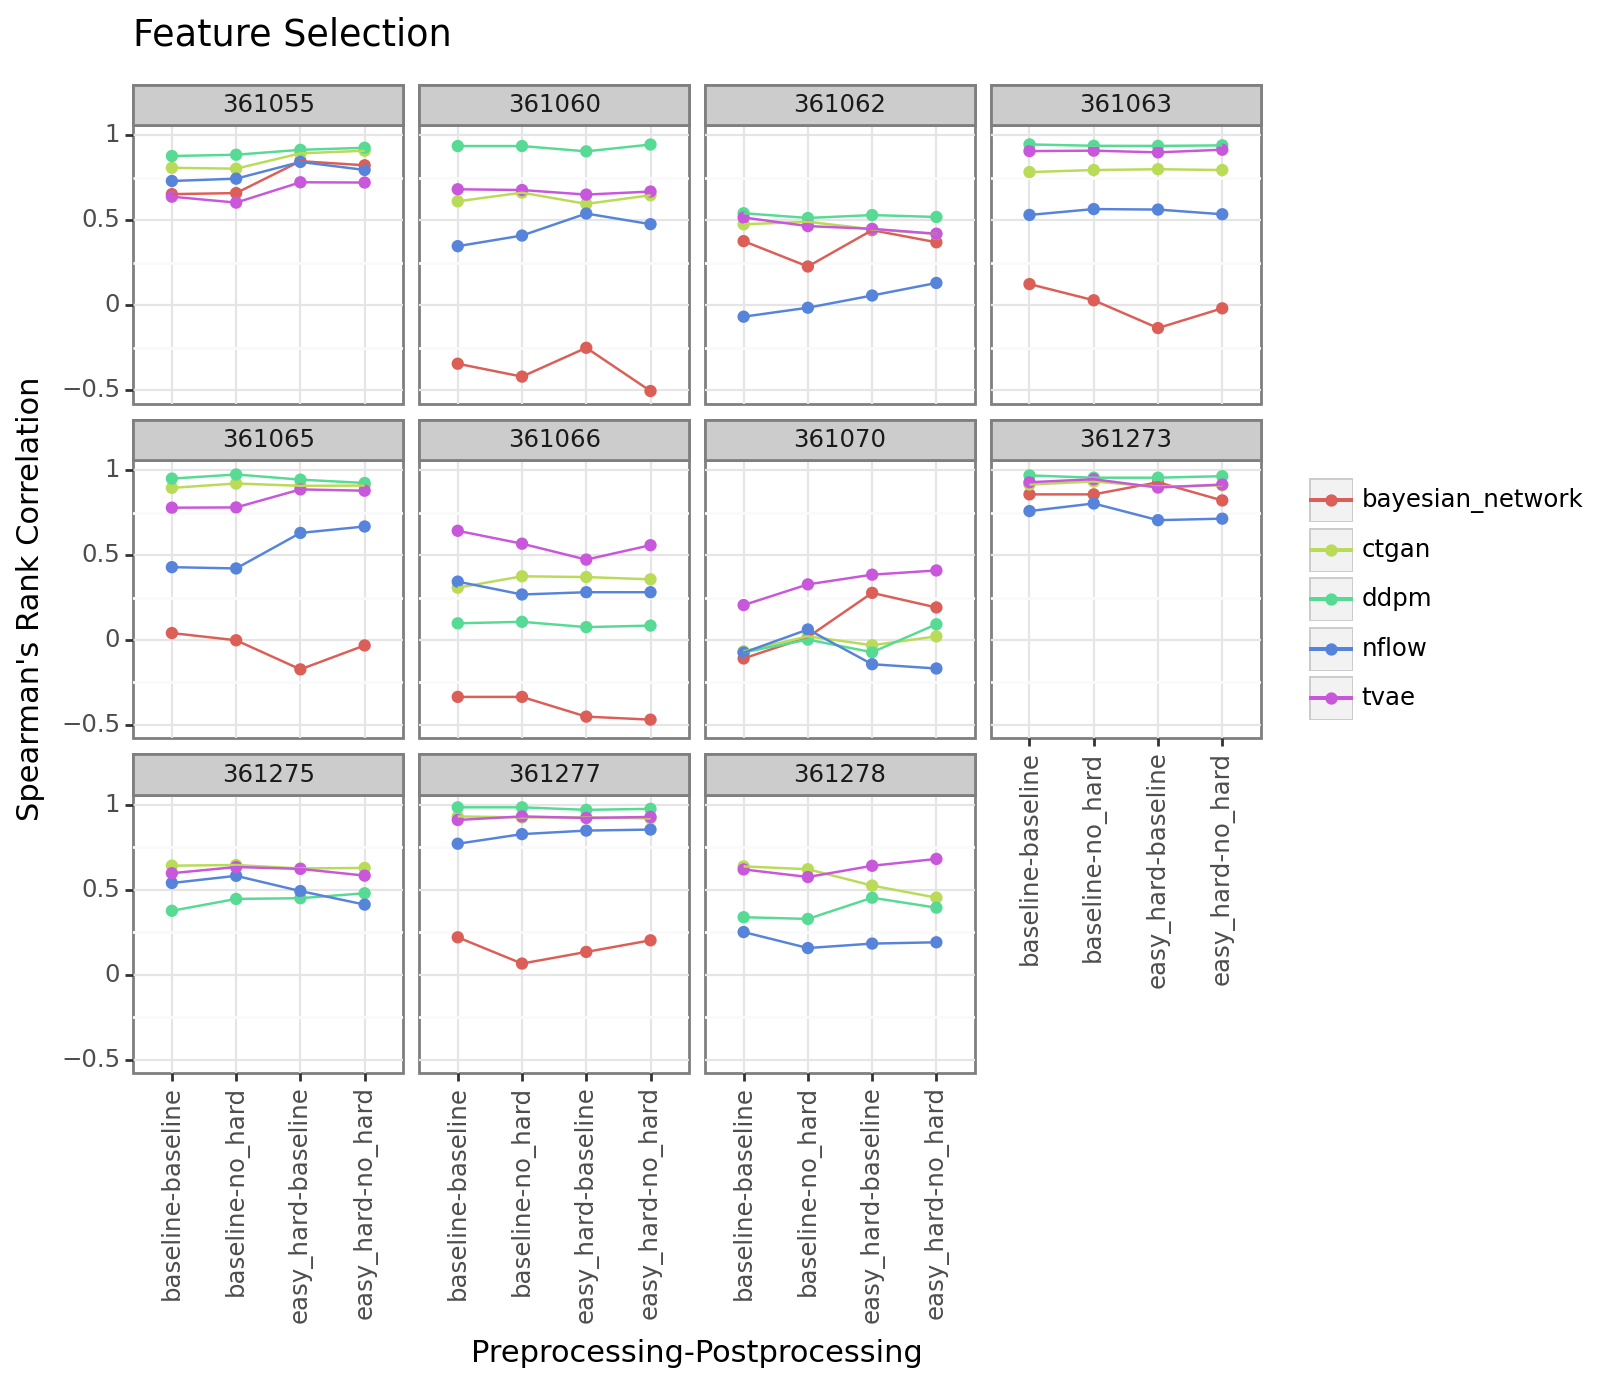

<Figure Size: (800 x 700)>

In [48]:

(
    plot_line_facet(combined.query("tasks == 'Feature Selection'"))
    + pn.labs(
        x="Preprocessing-Postprocessing",
        y="Spearman's Rank Correlation",
        title="Feature Selection",
    )
    + pn.theme(
        figure_size=(8, 7),
        axis_text_x=pn.element_text(rotation=90),
        legend_title=pn.element_blank(),
    )
)
